<a id='3'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Loading Libraries </h2> </div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Extraction </h2> </div>
In this part we are going to extract an image of each class we have.

In [ ]:
import os
import pandas as pd
import re

# Path where our data is located
base_path = "/content/drive/MyDrive/asl_dataset"

# Dictionary to save our 36 classes
categories = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
    6: "6", 7: "7", 8: "8", 9: "9", 10: "a", 11: "b",
    12: "c", 13: "d", 14: "e", 15: "f", 16: "g",
    17: "h", 18: "i", 19: "j", 20: "k", 21: "l",
    22: "m", 23: "n", 24: "o", 25: "p", 26: "q",
    27: "r", 28: "s", 29: "t", 30: "u", 31: "v",
    32: "w", 33: "x", 34: "y", 35: "z"
}

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1:re.search("_", x).start() + 2] + "/" + x
    )
    return df

# Lists containing all the filenames in the dataset and their corresponding category
filenames_list = []
categories_list = []

for category in categories:
    # Correct the path to include a slash between the base path and category
    path = os.path.join(base_path, categories[category])
    filenames = os.listdir(path)
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())


                             filename  category
0    n/hand2_n_top_seg_1_cropped.jpeg        23
1  2/hand2_2_right_seg_1_cropped.jpeg         2
2  o/hand2_o_right_seg_5_cropped.jpeg        24
3    5/hand2_5_top_seg_4_cropped.jpeg         5
4    k/hand1_k_dif_seg_2_cropped.jpeg        20


In [ ]:
df

,filename,category
0,n/hand2_n_top_seg_1_cropped.jpeg,23
1,2/hand2_2_right_seg_1_cropped.jpeg,2
2,o/hand2_o_right_seg_5_cropped.jpeg,24
3,5/hand2_5_top_seg_4_cropped.jpeg,5
4,k/hand1_k_dif_seg_2_cropped.jpeg,20
...,...,...
2520,3/hand2_3_right_seg_1_cropped.jpeg,3
2521,z/hand2_z_bot_seg_3_cropped.jpeg,35
2522,q/hand1_q_left_seg_1_cropped.jpeg,26
2523,i/hand2_i_left_seg_1_cropped.jpeg,18


In [ ]:
print("number of elements = ", len(df))

number of elements =  2525


<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

<h5 style="text-align:center;color:Green">We visualize few images of ASL. </h5>

In [ ]:
import matplotlib.pyplot as plt
import os

base_path = "/content/drive/MyDrive/asl_dataset/"

num_images_to_display = 25
grid_size = int(num_images_to_display ** 0.5)
plt.figure(figsize=(20, 20))

for i in range(num_images_to_display):

    path = os.path.join(base_path, df.filename[i])

    if not os.path.isfile(path):
        print(f"File not found: {path}")
        continue  # Skip the rest of the loop if file not found


    img = plt.imread(path)

    plt.subplot(grid_size, grid_size, i + 1)

    plt.imshow(img)

    if categories and df.category[i] in categories:
        plt.title(categories[df.category[i]], fontsize=12, fontstyle='italic')

    plt.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Now, we will see the distrubution of data in every class.

<ipython-input-9-34db056625d3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


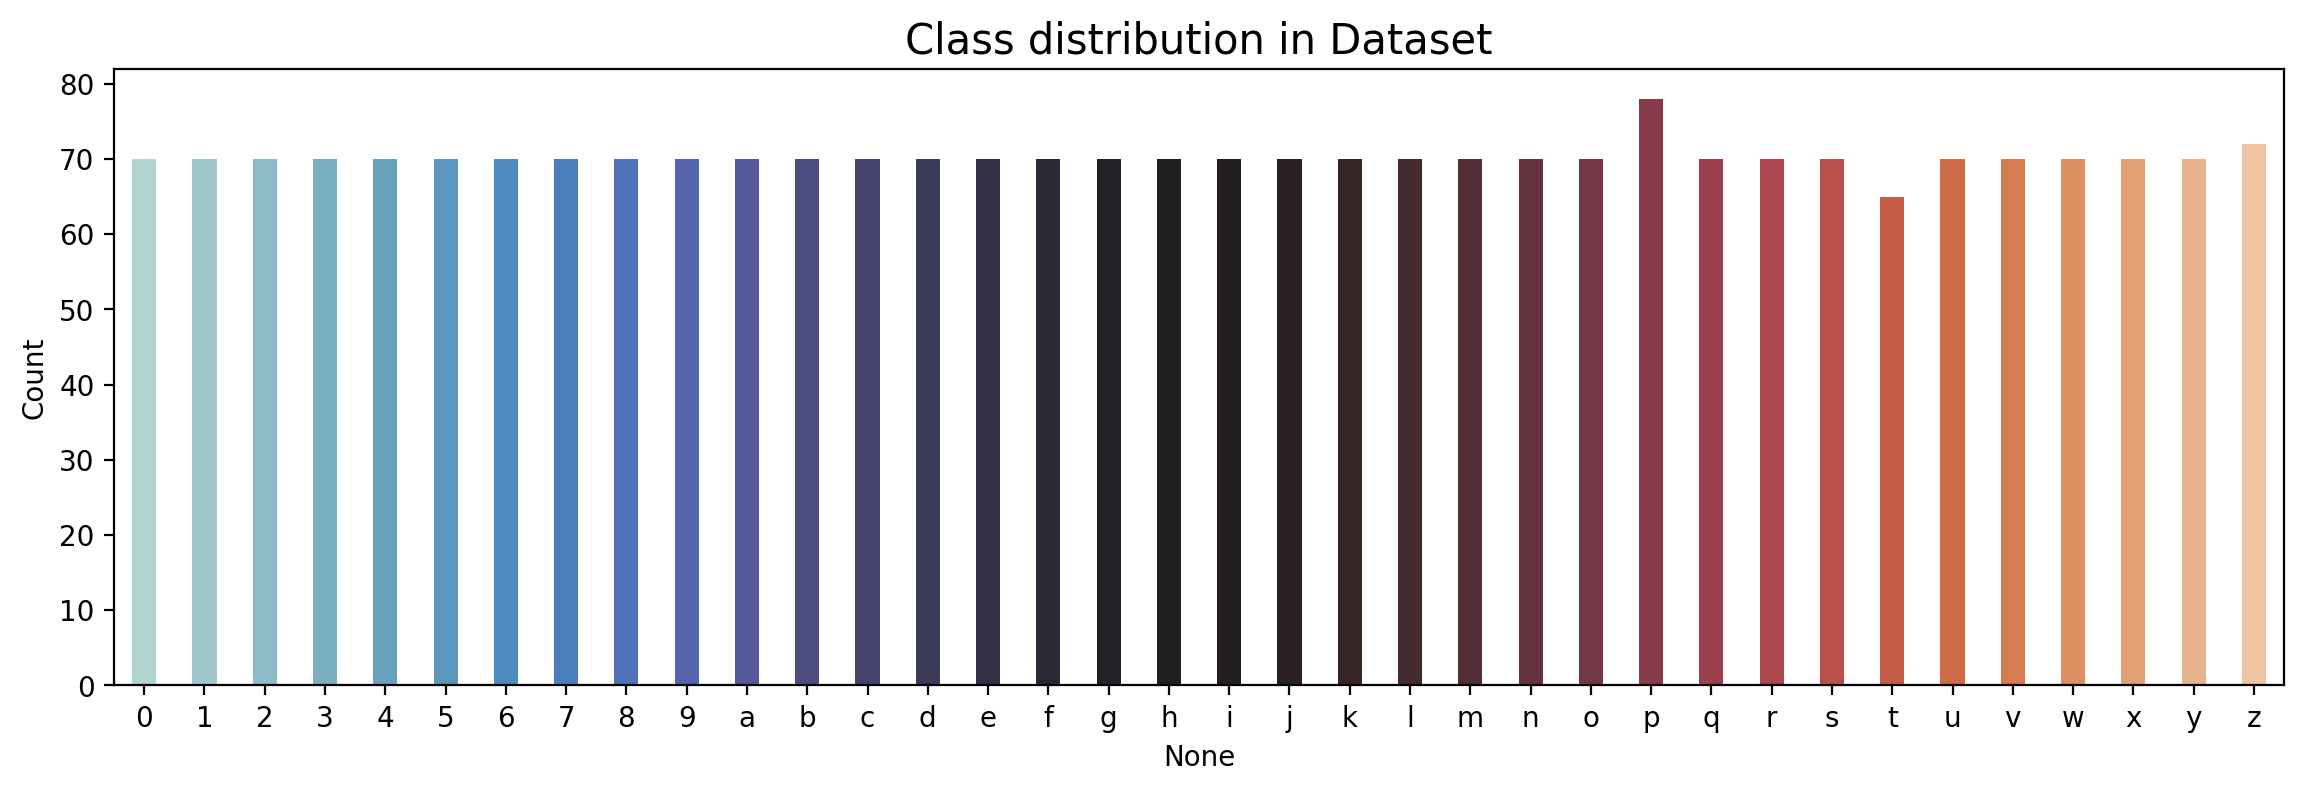

In [ ]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

We will split the data in three parts.
* Training dataset (80%)
* Validation dataset (10%)
* Testing dataset (10%)

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/asl_dataset/",output='/working/', seed=1333, ratio=(0.8,0.1,0.1))

Copying files: 2525 files [09:05,  4.62 files/s]


<a id='7'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

<a id='8'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Image Data Generator </h3> </div>

* The data for will used by flow_from_directory.
* The batch size is 32 and the image size is (150,150).
* The Image Data Generator will be used to rescale the images.

In [ ]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

Finally, we will list out all the important parameters and respective values.

In [ ]:
train_path = '/working/train'
val_path = '/working/val'
test_path = '/working/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

<a id='9'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Flow from Directory </h4> </div>

* We will import the data from directory.
* we will set **shuffle = False** for test data.

In [ ]:
train_data = datagen.flow_from_directory(directory= train_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path,
                                       target_size=(image_size,image_size),
                                       batch_size = batch,
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical',
                                         shuffle= False)

Found 2019 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 255 images belonging to 36 classes.


In [ ]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))
#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))
# fully connected layer
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(36, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
asl_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=10,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/10
64/64 [==============================] - 647s 10s/step - loss: 1.1304 - accuracy: 0.6761 - val_loss: 0.3089 - val_accuracy: 0.9084 - lr: 0.0010
Epoch 2/10
64/64 [==============================] - 646s 10s/step - loss: 0.4749 - accuracy: 0.8450 - val_loss: 0.2459 - val_accuracy: 0.9084 - lr: 0.0010
Epoch 3/10
64/64 [==============================] - 673s 11s/step - loss: 0.3039 - accuracy: 0.9024 - val_loss: 0.1667 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 4/10
64/64 [==============================] - 702s 11s/step - loss: 0.1795 - accuracy: 0.9430 - val_loss: 0.1375 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 5/10
64/64 [==============================] - 630s 10s/step - loss: 0.1299 - accuracy: 0.9564 - val_loss: 0.2194 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 6/10
64/64 [==============================] - 624s 10s/step - loss: 0.1131 - accuracy: 0.9633 - val_loss: 0.1019 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 7/10
64/64 [==============================] - 634s 10s/step - lo

<a id='15'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Evaluvation </h3> </div>

we will evaluvate the Training and validation data accuracy and loss.

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.95046854019165
The Loss of the model for training data is: 0.002585008041933179
The accuracy of the model for validation data is: 97.21115827560425
The Loss of the model for validation data is: 0.14522507786750793


<a id='16'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the results </h3> </div>

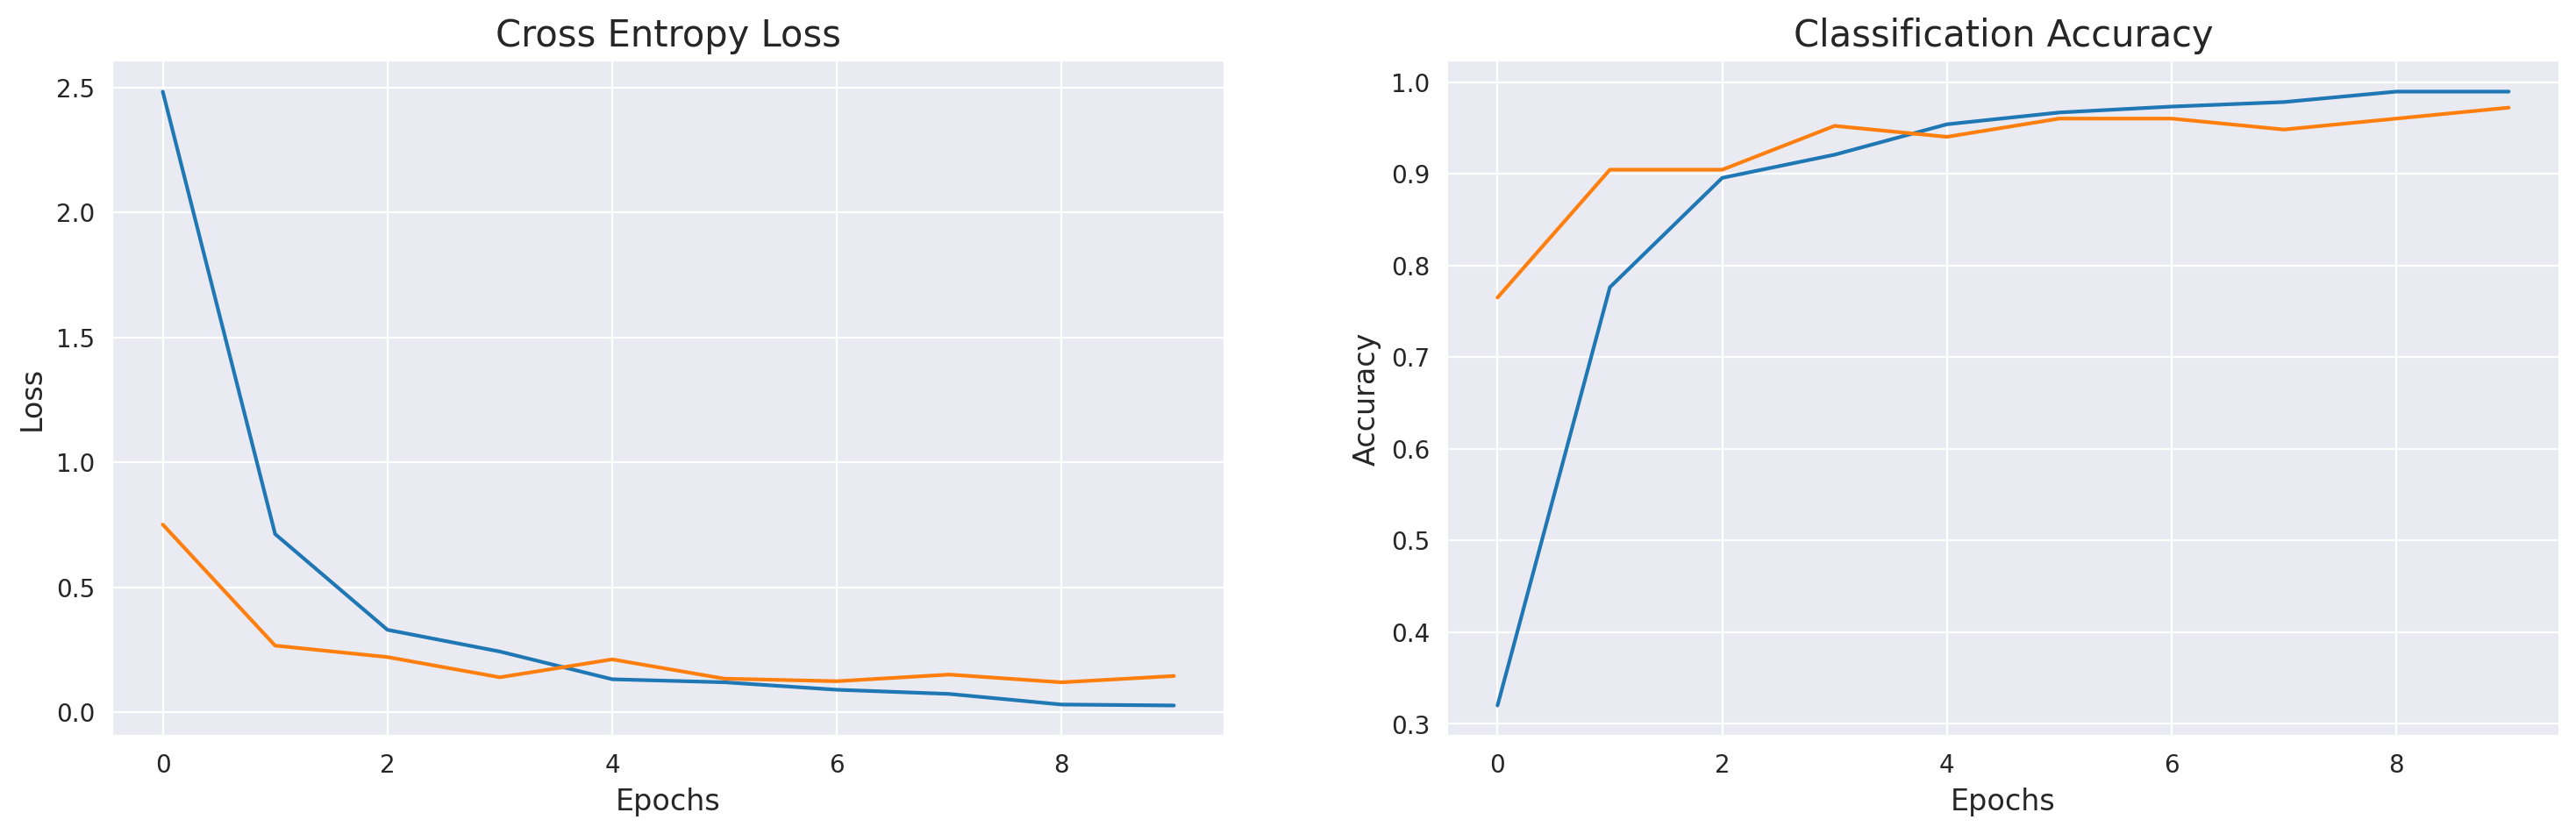

In [ ]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 93.72549057006836
The Loss of the model for testing data is: 0.35058847069740295


The count of correctly and incorrectly classified images.

In [ ]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 239
Incorrect predicted classes: 16


Classification report

In [ ]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       0.70      1.00      0.82         7
           2       0.86      0.86      0.86         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      0.86      0.92         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
           h       1.00    

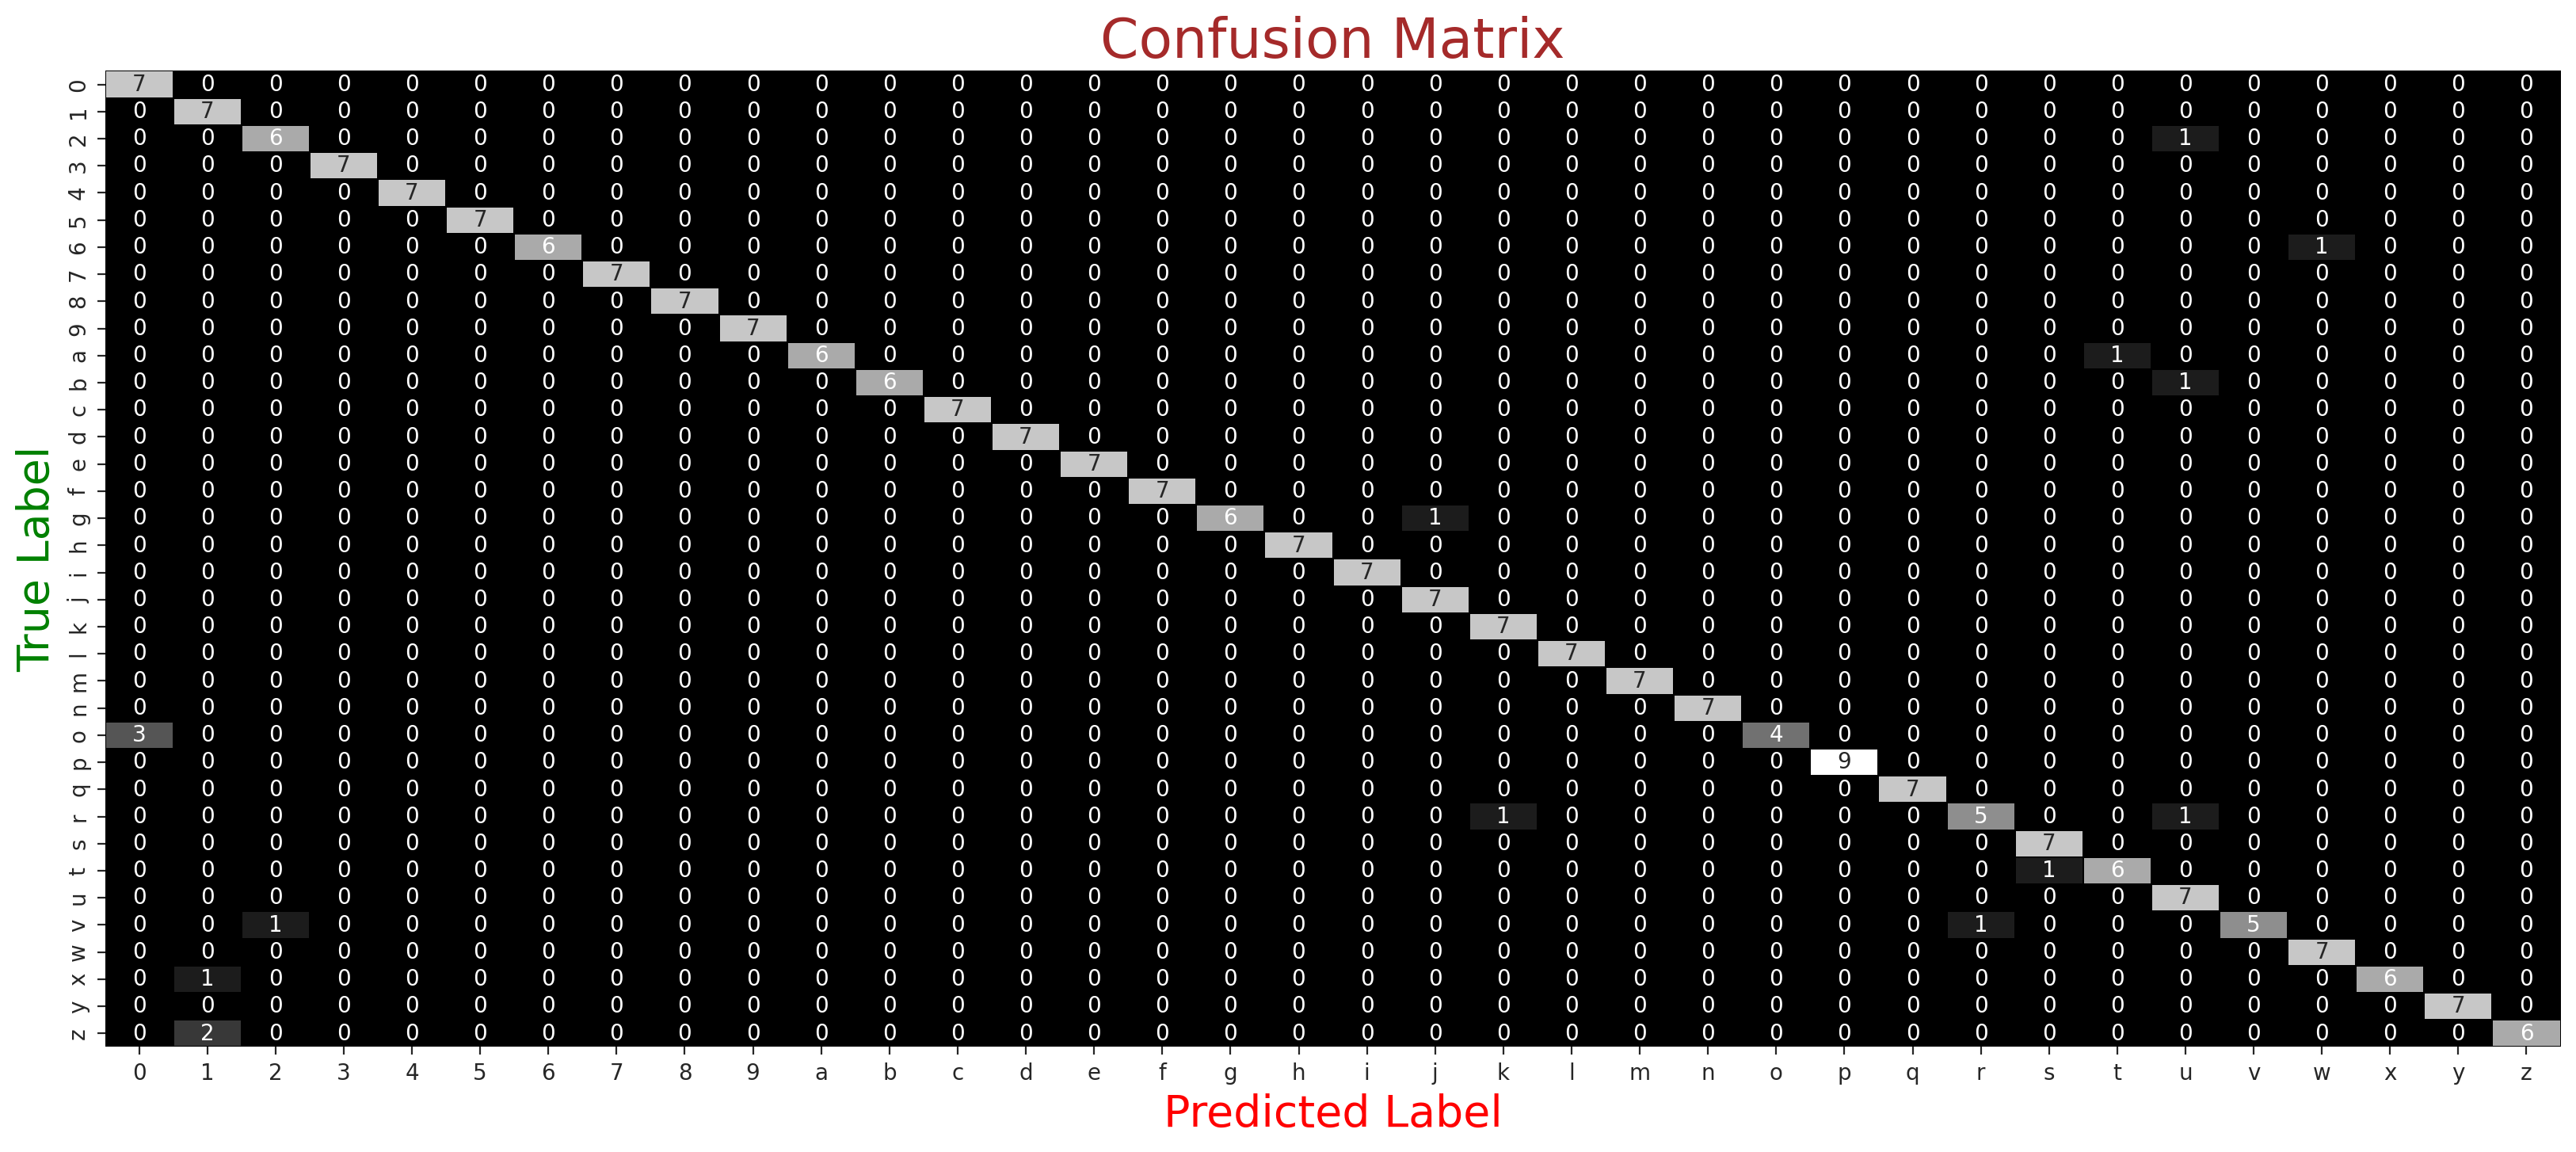

In [ ]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax,
            cbar=False, xticklabels=categories.values(),
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [ ]:
!pip install tensorflow
!pip install keras

1/1 [==============================] - 0s 47ms/step
Predicted class: 9


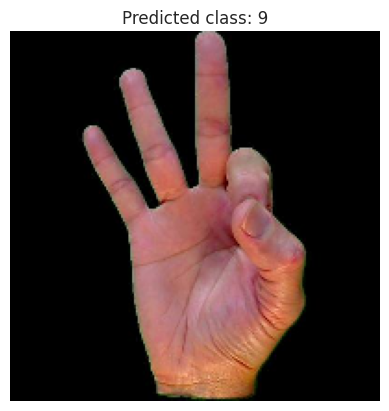

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_size = 64
img_channel = 3
# Assuming the expected image size is 200x200
expected_image_size = 200

sample_image_path = '/content/fdg.jpeg'
image = load_img(sample_image_path, target_size=(expected_image_size, expected_image_size))
image = img_to_array(image)
image = image / 255.0
image = np.expand_dims(image, axis=0)

prediction = model.predict(image)
predicted_class = np.argmax(prediction, axis=1)
predicted_class_name = categories[predicted_class[0]]

print("Predicted class:", predicted_class_name)

import matplotlib.pyplot as plt

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off')
plt.show()